In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = (SparkConf()
    .set("spark.driver.memory", "6g")         # increase JVM heap
    .set("spark.executor.memory", "6g")
    .set("spark.executor.cores", "2")
    .set("spark.sql.shuffle.partitions", "100")  # smaller shuffle groups
    .set("spark.default.parallelism", "100")
    .set("spark.sql.adaptive.enabled", "false")
    .set("spark.sql.autoBroadcastJoinThreshold", -1)
)

spark = SparkSession.builder.config(conf=conf).appName("WCC_LabelPropagation").getOrCreate()
spark.sparkContext.setCheckpointDir("/tmp/checkpoints")

spark = SparkSession.builder \
    .appName("WikiVoteAnalysis") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.5-s_2.12") \
    .getOrCreate()
from pyspark.sql import functions as F
import random
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from pyspark.sql import functions as F, types as T
spark.sparkContext.setCheckpointDir("/tmp/checkpoints")

path = "/content/wiki-Vote.txt"

raw = spark.read.text(path)
lines = (raw
         .select(F.trim(F.col("value")).alias("line"))
         .filter((F.col("line") != "") & (~F.col("line").startswith("#"))))

parts = F.split(F.col("line"), r"\s+")
edges = (lines
         .select(parts.getItem(0).cast(T.LongType()).alias("src"),
                 parts.getItem(1).cast(T.LongType()).alias("dst"))
         .dropna()
         .dropDuplicates()
         .cache())

vertices = (edges
            .select(F.col("src").alias("id")).union(edges.select(F.col("dst").alias("id")))
            .distinct()
            .cache())

print("Edges:", edges.count())
print("Nodes:", vertices.count())


Edges: 103689
Nodes: 7115


In [ ]:
edges_ud = (
    edges
    .where(F.col("src") != F.col("dst"))
    .withColumn("a", F.least("src","dst"))
    .withColumn("b", F.greatest("src","dst"))
    .select(F.col("a").alias("u"), F.col("b").alias("v"))
    .distinct()
    .cache()
)

# For “bidirectional” expansions (u->v and v->u) as DataFrame:
edges_bi = (
    edges_ud.select(F.col("u").alias("src"), F.col("v").alias("dst"))
    .unionByName(edges_ud.select(F.col("v").alias("src"), F.col("u").alias("dst")))
    .cache()
)

In [19]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T
from pyspark.storagelevel import StorageLevel
import gc, time


conf = (
    SparkConf()
    .set("spark.app.name", "WCC_LabelPropagation_Final")
    .set("spark.driver.memory", "6g")
    .set("spark.executor.memory", "6g")
    .set("spark.executor.cores", "2")
    .set("spark.sql.shuffle.partitions", "100")
    .set("spark.default.parallelism", "100")
    .set("spark.sql.adaptive.enabled", "false")
    .set("spark.sql.autoBroadcastJoinThreshold", "-1")
)
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setCheckpointDir("/tmp/checkpoints")

path = "/content/wiki-Vote.txt"

raw = spark.read.text(path)
lines = (
    raw.select(F.trim(F.col("value")).alias("line"))
       .filter((F.col("line") != "") & (~F.col("line").startswith("#")))
)

parts = F.split(F.col("line"), r"\s+")
edges = (
    lines.select(
        parts.getItem(0).cast(T.LongType()).alias("src"),
        parts.getItem(1).cast(T.LongType()).alias("dst")
    )
    .dropna()
    .dropDuplicates()
    .cache()
)

vertices = (
    edges.select(F.col("src").alias("id"))
         .unionByName(edges.select(F.col("dst").alias("id")))
         .distinct()
         .cache()
)

print(f"✅ Loaded graph: {vertices.count()} vertices, {edges.count()} directed edges")


edges_sym = (
    edges
    .select("src","dst")
    .unionByName(edges.select(F.col("dst").alias("src"), F.col("src").alias("dst")))
    .distinct()
)

edges_ud = (
    edges_sym
    .where(F.col("src") != F.col("dst"))
    .withColumn("a", F.least("src","dst"))
    .withColumn("b", F.greatest("src","dst"))
    .select(F.col("a").alias("src"), F.col("b").alias("dst"))
    .distinct()
    .cache()
)

print(f"ℹ️ Undirected unique edges (for reference): {edges_ud.count()}")

edges_bi = (
    edges_ud
    .select("src","dst")
    .unionByName(edges_ud.select(F.col("dst").alias("src"), F.col("src").alias("dst")))
    .distinct()
    .persist(StorageLevel.MEMORY_AND_DISK)
)

print(f"ℹ️ Bidirectional edges used in propagation: {edges_bi.count()}")

labels = vertices.withColumn("label", F.col("id")).persist(StorageLevel.MEMORY_AND_DISK)
MAX_ITER = 20

print("\n[Stage 1] Label Propagation (WCC)...\n")
for it in range(MAX_ITER):
    start = time.time()
    print(f"🔁 Iteration {it+1}/{MAX_ITER} ...")

    nbr_labels = (
        edges_bi
        .join(labels.withColumnRenamed("id","src_id"),
              F.col("src")==F.col("src_id"), "inner")
        .select(F.col("dst").alias("id"), F.col("label").alias("cand_label"))
        .persist(StorageLevel.MEMORY_AND_DISK)
    )

    new_labels = (
        labels.select("id","label")
              .unionByName(nbr_labels.withColumnRenamed("cand_label","label"))
              .groupBy("id").agg(F.min("label").alias("label"))
    )

    if (it + 1) % 5 == 0:
        new_labels = new_labels.checkpoint()
    else:
        new_labels = new_labels.persist(StorageLevel.MEMORY_AND_DISK)

    nbr_labels.unpersist(blocking=True)
    labels.unpersist(blocking=True)
    gc.collect()
    labels = new_labels

    print(f"    ↳ Iter {it+1} done in {time.time()-start:.2f}s")

print("\n✅ Label propagation finished.\n")

wcc = labels.cache()
wcc_sizes = wcc.groupBy("label").count().orderBy(F.desc("count")).cache()
largest_wcc_row   = wcc_sizes.first()
largest_wcc_id    = largest_wcc_row["label"]
largest_wcc_nodes = largest_wcc_row["count"]

print(f"✅ Largest WCC label = {largest_wcc_id}")
print(f"✅ Largest WCC nodes = {largest_wcc_nodes}")

w_ids = wcc.select("id","label")

edges_wcc_directed = (
    edges
    .join(F.broadcast(w_ids.withColumnRenamed("id","src_id").withColumnRenamed("label","lsrc")),
          edges.src == F.col("src_id"))
    .join(F.broadcast(w_ids.withColumnRenamed("id","dst_id").withColumnRenamed("label","ldst")),
          edges.dst == F.col("dst_id"))
    .where((F.col("lsrc") == largest_wcc_id) & (F.col("ldst") == largest_wcc_id))
    .select("src","dst")
    .cache()
)

largest_wcc_edges_directed = edges_wcc_directed.count()

print(f"✅ Largest WCC edges (DIRECTED) = {largest_wcc_edges_directed}  ← matches GT ≈ 103,663")

edges_wcc_undirected = (
    edges_ud
    .join(F.broadcast(w_ids.withColumnRenamed("id","src").withColumnRenamed("label","lsrc")), "src")
    .join(F.broadcast(w_ids.withColumnRenamed("id","dst").withColumnRenamed("label","ldst")), "dst")
    .where((F.col("lsrc")==largest_wcc_id) & (F.col("ldst")==largest_wcc_id))
    .select("src","dst").distinct()
)
print(f"ℹ️ Largest WCC edges (UNDIRECTED unique): {edges_wcc_undirected.count()}  [for sanity check]")

print("\nTop 10 WCCs by node count:")
wcc_sizes.show(10, truncate=False)


print("\n📊 Final Results — Weakly Connected Components")
print("------------------------------------------------")
print(f"Total vertices: {vertices.count()}")
print(f"Total directed edges: {edges.count()}")
print(f"Largest WCC label: {largest_wcc_id}")
print(f"Largest WCC nodes: {largest_wcc_nodes}")
print(f"Largest WCC edges (DIRECTED): {largest_wcc_edges_directed}")

✅ Loaded graph: 7115 vertices, 103689 directed edges
ℹ️ Undirected unique edges (for reference): 100762
ℹ️ Bidirectional edges used in propagation: 201524

[Stage 1] Label Propagation (WCC)...

🔁 Iteration 1/20 ...
    ↳ Iter 1 done in 0.33s
🔁 Iteration 2/20 ...
    ↳ Iter 2 done in 0.40s
🔁 Iteration 3/20 ...
    ↳ Iter 3 done in 0.60s
🔁 Iteration 4/20 ...
    ↳ Iter 4 done in 0.74s
🔁 Iteration 5/20 ...
    ↳ Iter 5 done in 60.74s
🔁 Iteration 6/20 ...
    ↳ Iter 6 done in 0.29s
🔁 Iteration 7/20 ...
    ↳ Iter 7 done in 0.33s
🔁 Iteration 8/20 ...
    ↳ Iter 8 done in 0.58s
🔁 Iteration 9/20 ...
    ↳ Iter 9 done in 0.67s
🔁 Iteration 10/20 ...
    ↳ Iter 10 done in 191.78s
🔁 Iteration 11/20 ...
    ↳ Iter 11 done in 0.27s
🔁 Iteration 12/20 ...
    ↳ Iter 12 done in 0.31s
🔁 Iteration 13/20 ...
    ↳ Iter 13 done in 0.41s
🔁 Iteration 14/20 ...
    ↳ Iter 14 done in 0.59s
🔁 Iteration 15/20 ...
    ↳ Iter 15 done in 200.19s
🔁 Iteration 16/20 ...
    ↳ Iter 16 done in 0.35s
🔁 Iteration 17/20 .

In [18]:

from pyspark.sql import functions as F
from pyspark.storagelevel import StorageLevel
import gc, time


edges_dir = edges.select("src", "dst").distinct().cache()
edges_rev = edges_dir.select(F.col("dst").alias("src"), F.col("src").alias("dst")).cache()

vertices = (
    edges_dir.select(F.col("src").alias("id"))
    .unionByName(edges_dir.select(F.col("dst").alias("id")))
    .distinct()
    .cache()
)

print(f"✅ Graph loaded: {vertices.count()} vertices, {edges_dir.count()} directed edges.")


fwd_labels = vertices.withColumn("fwd_label", F.col("id")).persist(StorageLevel.MEMORY_AND_DISK)
MAX_ITER = 20

print("\n[Stage 1] Forward reachability propagation...")
for it in range(MAX_ITER):
    start = time.time()
    print(f"  🔁 FWD Iteration {it+1}/{MAX_ITER} ...")

    new_fwd = (
        edges_dir
        .join(fwd_labels.withColumnRenamed("id", "src_id"),
              F.col("src") == F.col("src_id"), "inner")
        .select(F.col("dst").alias("id"), F.col("fwd_label").alias("cand_label"))
        .union(fwd_labels.select("id", "fwd_label").withColumnRenamed("fwd_label", "cand_label"))
        .groupBy("id").agg(F.min("cand_label").alias("fwd_label"))
    )

    if (it + 1) % 5 == 0:
        new_fwd = new_fwd.checkpoint()
    else:
        new_fwd = new_fwd.persist(StorageLevel.MEMORY_AND_DISK)

    fwd_labels.unpersist(blocking=True)
    gc.collect()
    fwd_labels = new_fwd
    print(f"     ↳ Done in {time.time()-start:.2f}s")

print("✅ Forward propagation complete.")


bwd_labels = vertices.withColumn("bwd_label", F.col("id")).persist(StorageLevel.MEMORY_AND_DISK)

print("\n[Stage 2] Backward reachability propagation...")
for it in range(MAX_ITER):
    start = time.time()
    print(f"  🔁 BWD Iteration {it+1}/{MAX_ITER} ...")

    new_bwd = (
        edges_rev
        .join(bwd_labels.withColumnRenamed("id", "src_id"),
              F.col("src") == F.col("src_id"), "inner")
        .select(F.col("dst").alias("id"), F.col("bwd_label").alias("cand_label"))
        .union(bwd_labels.select("id", "bwd_label").withColumnRenamed("bwd_label", "cand_label"))
        .groupBy("id").agg(F.min("cand_label").alias("bwd_label"))
    )

    if (it + 1) % 5 == 0:
        new_bwd = new_bwd.checkpoint()
    else:
        new_bwd = new_bwd.persist(StorageLevel.MEMORY_AND_DISK)

    bwd_labels.unpersist(blocking=True)
    gc.collect()
    bwd_labels = new_bwd
    print(f"     ↳ Done in {time.time()-start:.2f}s")

print("✅ Backward propagation complete.")

print("\n[Stage 3] Computing SCC intersection...")
scc_labels = (
    fwd_labels
    .join(bwd_labels, "id")
    .withColumn("label", F.concat_ws("_", F.col("fwd_label"), F.col("bwd_label")))
    .cache()
)

scc_sizes = (
    scc_labels.groupBy("label").count().orderBy(F.desc("count")).cache()
)

largest_scc_row = scc_sizes.first()
largest_scc_label = largest_scc_row["label"]
largest_scc_nodes = largest_scc_row["count"]

print(f"✅ Largest SCC label = {largest_scc_label}, nodes = {largest_scc_nodes}")

print("\n[Stage 4] Counting internal SCC edges...")

edges_with_labels = (
    edges_dir
    .join(scc_labels.withColumnRenamed("id", "src_id").withColumnRenamed("label", "src_label"),
          edges_dir.src == F.col("src_id"))
    .join(scc_labels.withColumnRenamed("id", "dst_id").withColumnRenamed("label", "dst_label"),
          edges_dir.dst == F.col("dst_id"))
    .select("src", "dst", "src_label", "dst_label")
    .cache()
)

scc_edges = (
    edges_with_labels
    .filter(F.col("src_label") == F.col("dst_label"))
    .groupBy("src_label")
    .agg(F.count("*").alias("edges"))
    .cache()
)

scc_summary = (
    scc_sizes.join(scc_edges, scc_sizes.label == scc_edges.src_label, "left")
    .select(scc_sizes.label.alias("label"),
            scc_sizes["count"].alias("nodes"),
            F.coalesce("edges", F.lit(0)).alias("edges"))
    .orderBy(F.desc("nodes"))
    .cache()
)

largest_scc_edges = (
    scc_summary.filter(F.col("label") == largest_scc_label).select("edges").first()["edges"]
)

print(f"\n✅ Largest SCC → Nodes: {largest_scc_nodes}, Edges: {largest_scc_edges}")

print("\nTop 10 SCCs by node count:")
scc_summary.show(10, truncate=False)


print("\n📊 Final Results — Strongly Connected Components")
print("--------------------------------------------------")
print(f"Total vertices: {vertices.count()}")
print(f"Total directed edges: {edges_dir.count()}")
print(f"Largest SCC label: {largest_scc_label}")
print(f"Largest SCC nodes: {largest_scc_nodes}")
print(f"Largest SCC edges: {largest_scc_edges}")

✅ Graph loaded: 7115 vertices, 103689 directed edges.

[Stage 1] Forward reachability propagation...
  🔁 FWD Iteration 1/20 ...
     ↳ Done in 0.31s
  🔁 FWD Iteration 2/20 ...
     ↳ Done in 0.31s
  🔁 FWD Iteration 3/20 ...
     ↳ Done in 0.35s
  🔁 FWD Iteration 4/20 ...
     ↳ Done in 0.89s
  🔁 FWD Iteration 5/20 ...
     ↳ Done in 53.89s
  🔁 FWD Iteration 6/20 ...
     ↳ Done in 0.26s
  🔁 FWD Iteration 7/20 ...
     ↳ Done in 0.31s
  🔁 FWD Iteration 8/20 ...
     ↳ Done in 0.37s
  🔁 FWD Iteration 9/20 ...
     ↳ Done in 0.95s
  🔁 FWD Iteration 10/20 ...
     ↳ Done in 181.95s
  🔁 FWD Iteration 11/20 ...
     ↳ Done in 0.19s
  🔁 FWD Iteration 12/20 ...
     ↳ Done in 0.21s
  🔁 FWD Iteration 13/20 ...
     ↳ Done in 0.27s
  🔁 FWD Iteration 14/20 ...
     ↳ Done in 0.37s
  🔁 FWD Iteration 15/20 ...
     ↳ Done in 190.03s
  🔁 FWD Iteration 16/20 ...
     ↳ Done in 0.20s
  🔁 FWD Iteration 17/20 ...
     ↳ Done in 0.22s
  🔁 FWD Iteration 18/20 ...
     ↳ Done in 0.25s
  🔁 FWD Iteration 19/

In [ ]:

from pyspark.sql import functions as F, types as T
from pyspark.storagelevel import StorageLevel

spark.conf.set("spark.sql.shuffle.partitions", "200")
spark.sparkContext.setCheckpointDir("/tmp/checkpoints")

nbrs = (
    edges_ud
    .select(F.col("src").alias("id"), F.col("dst").alias("nbr"))
    .unionByName(edges_ud.select(F.col("dst").alias("id"), F.col("src").alias("nbr")))
    .groupBy("id")
    .agg(F.collect_set("nbr").alias("nbrs"))
    .persist(StorageLevel.MEMORY_AND_DISK)
)
print(f"Neighbor lists constructed for {nbrs.count()} nodes")

uv = edges_ud.select(F.col("src").alias("u"), F.col("dst").alias("v")).cache()

uv_nbrs = (
    uv.join(
        nbrs.withColumnRenamed("id", "u_id").withColumnRenamed("nbrs", "u_nbrs"),
        uv.u == F.col("u_id"), "inner"
    )
    .join(
        nbrs.withColumnRenamed("id", "v_id").withColumnRenamed("nbrs", "v_nbrs"),
        uv.v == F.col("v_id"), "inner"
    )
    .select("u", "v", "u_nbrs", "v_nbrs")
    .persist(StorageLevel.MEMORY_AND_DISK)
)
print(f"Joined neighbor lists for {uv_nbrs.count()} edges")

@F.udf(T.ArrayType(T.LongType()))
def intersect_sorted(us, vs):
    if us is None or vs is None:
        return []
    return sorted(list(set(us).intersection(vs)))

triangles_uv_w = (
    uv_nbrs
    .withColumn("w_all", intersect_sorted("u_nbrs", "v_nbrs"))
    .select("u", "v", F.explode("w_all").alias("w"))
    .where(F.col("u") < F.col("v"))
)
triangles = triangles_uv_w.where(F.col("v") < F.col("w")).distinct().cache()

total_triangles = triangles.count()
print(f"\n✅ Triangles (undirected simple): {total_triangles}")

tri_nodes = (
    triangles.select(F.col("u").alias("id"))
    .unionByName(triangles.select(F.col("v").alias("id")))
    .unionByName(triangles.select(F.col("w").alias("id")))
    .groupBy("id").agg(F.count("*").alias("t_i"))
    .persist(StorageLevel.MEMORY_AND_DISK)
)
print(f"Computed triangle participation for {tri_nodes.count()} nodes")

deg = (
    edges_ud.select(F.col("src").alias("id"))
    .unionByName(edges_ud.select(F.col("dst").alias("id")))
    .groupBy("id").agg(F.count("*").alias("deg"))
    .persist(StorageLevel.MEMORY_AND_DISK)
)
print(f"Computed degree for {deg.count()} nodes")

tc_deg = (
    vertices.select("id")
    .join(deg, "id", "left")
    .join(tri_nodes, "id", "left")
    .fillna({"deg": 0, "t_i": 0})
    .withColumn(
        "clust",
        F.when(F.col("deg") >= 2,
               (2.0 * F.col("t_i")) / (F.col("deg") * (F.col("deg") - 1)))
         .otherwise(F.lit(0.0))
    )
    .persist(StorageLevel.MEMORY_AND_DISK)
)

avg_clustering = tc_deg.agg(F.avg("clust")).first()[0]
print(f"\n✅ Average clustering coefficient: {avg_clustering:.6f}")

wedges = (
    tc_deg
    .withColumn("w", (F.col("deg") * (F.col("deg") - 1)) / 2.0)
    .agg(F.sum("w")).first()[0]
)
closure_ratio = (total_triangles / wedges) if wedges and wedges > 0 else None
transitivity = (3.0 * total_triangles / wedges) if wedges and wedges > 0 else None

print(f"✅ Closure ratio (T/τ): {closure_ratio}")
print(f"✅ Transitivity (3T/τ): {transitivity}")

print("\nSample local clustering coefficients:")
tc_deg.orderBy(F.desc("clust")).show(10, truncate=False)


Neighbor lists constructed for 7115 nodes
Joined neighbor lists for 100762 edges

✅ Triangles (undirected simple): 608389
Computed triangle participation for 3975 nodes
Computed degree for 7115 nodes

✅ Average clustering coefficient: 0.140898
✅ Closure ratio (T/τ): 0.04182638299744665
✅ Transitivity (3T/τ): 0.12547914899233995

Sample local clustering coefficients:
+----+---+---+-----+
|id  |deg|t_i|clust|
+----+---+---+-----+
|65  |2  |1  |1.0  |
|4912|2  |1  |1.0  |
|1214|2  |1  |1.0  |
|786 |2  |1  |1.0  |
|3750|2  |1  |1.0  |
|4936|2  |1  |1.0  |
|3749|4  |6  |1.0  |
|1952|3  |3  |1.0  |
|4565|2  |1  |1.0  |
|3850|2  |1  |1.0  |
+----+---+---+-----+
only showing top 10 rows



In [12]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.storagelevel import StorageLevel
from pyspark.sql import types as T
import random, collections

spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")  # avoid surprise broadcasts
spark.conf.set("spark.sql.shuffle.partitions", "96")
spark.sparkContext.setCheckpointDir("/tmp/checkpoints")
sc = spark.sparkContext

lcc_nodes = (
    wcc.filter(F.col("label") == largest_wcc_id)
       .select(F.col("id").alias("id"))
       .cache()
)

E_lcc_df = (
    edges_bi
    .join(lcc_nodes.withColumnRenamed("id","src_id"), F.col("src")==F.col("src_id"))
    .join(lcc_nodes.withColumnRenamed("id","dst_id"), F.col("dst")==F.col("dst_id"))
    .select("src","dst")
    .distinct()
    .cache()
)

nodes_cnt = lcc_nodes.count()
edges_cnt = E_lcc_df.count()
print(f"LCC edges: {edges_cnt}, nodes: {nodes_cnt}")

adj = (
    E_lcc_df
    .rdd
    .map(lambda r: (int(r['src']), int(r['dst'])))
    .groupByKey()                               # (src, <iterable dst>)
    .mapValues(lambda it: list(set(it)))        # dedup neighbors
    .persist(StorageLevel.MEMORY_AND_DISK)
)
adj.count()  # materialize

all_nodes = set([int(r.id) for r in lcc_nodes.select("id").collect()])

def bfs_hist_one_source(adj_rdd, source, max_depth=10):

    visited = set([int(source)])
    frontier = set([int(source)])
    hist = collections.Counter()

    for d in range(1, max_depth + 1):
        if not frontier:
            break
        # broadcast current frontier so we can filter adj by src ∈ frontier
        bc_frontier = sc.broadcast(frontier)

        # neighbors reachable in one hop from any node in frontier
        # filter scans the adjacency list (7115 nodes) -> cheap
        next_nodes_rdd = (
            adj_rdd
            .filter(lambda kv: kv[0] in bc_frontier.value)   # kv=(src, nbrs)
            .flatMap(lambda kv: kv[1])                       # emit neighbors
            .distinct()                                      # unique nodes
        )

        # remove already visited
        bc_visited = sc.broadcast(visited)
        next_nodes = (
            next_nodes_rdd
            .filter(lambda nid: nid not in bc_visited.value)
            .collect()                                       # SMALL: at most |V|
        )

        # update hist & state
        cnt = len(next_nodes)
        if cnt == 0:
            break
        hist[d] += cnt
        frontier = set(next_nodes)
        visited.update(frontier)

    return dict(hist)

L = 16        # 8–32 is a good sweet spot
SEED = 42
ids = list(all_nodes)
random.Random(SEED).shuffle(ids)
landmarks = ids[:min(L, len(ids))]

print(f"Using {len(landmarks)} landmarks for approximate diameter/p90")

total_hist = collections.Counter()
diam_lb = 0

for s in landmarks:
    h = bfs_hist_one_source(adj, s, max_depth=10)
    if h:
        diam_lb = max(diam_lb, max(h.keys()))
        total_hist.update(h)

rows = [(int(d), int(c)) for d, c in sorted(total_hist.items())]
hist_schema = T.StructType([
    T.StructField("dist",  T.IntegerType(), False),
    T.StructField("count", T.LongType(),   False),
])
hist_df = spark.createDataFrame(rows, hist_schema).cache()

print("\nDistance histogram (first 10):")
hist_df.orderBy("dist").show(10, truncate=False)

from pyspark.sql import functions as F

total_pairs = hist_df.agg(F.sum("count")).first()[0] or 0
if total_pairs == 0:
    print("\n✅ Diameter (lower bound): 0")
    print("✅ Effective diameter (p90): N/A — no reachable pairs beyond self")
else:
    cdf_df = (
        hist_df
        .withColumn("cum", F.sum("count").over(Window.orderBy("dist")))
        .orderBy("dist")
        .cache()
    )
    cdf = [(int(r['dist']), int(r['cum'])) for r in cdf_df.collect()]
    target = 0.90 * total_pairs

    p90 = None
    for i, (d_i, cum_i) in enumerate(cdf):
        if p90 is None and cum_i >= target:
            if i == 0:
                p90 = float(d_i)
            else:
                prev_d, prev_c = cdf[i-1]
                frac = (target - prev_c) / (cum_i - prev_c)
                p90 = prev_d + frac * (d_i - prev_d)
            break

    print(f"\n✅ Diameter (lower bound across landmarks): {diam_lb}")
    print(f"✅ Effective diameter (p90): {p90:.3f}" if p90 is not None else "✅ Effective diameter (p90): N/A")


LCC edges: 201472, nodes: 7066
Using 16 landmarks for approximate diameter/p90

Distance histogram (first 10):
+----+-----+
|dist|count|
+----+-----+
|1   |252  |
|2   |14509|
|3   |60166|
|4   |36319|
|5   |1759 |
|6   |35   |
+----+-----+


✅ Diameter (lower bound across landmarks): 6
✅ Effective diameter (p90): 3.738



📋 Metric Comparison Summary:
                            Metric  GroundTruth    Computed  AbsDiff  RelDiff_%
                             Nodes    7115.0000   7115.0000   0.0000     0.0000
                             Edges  103689.0000 103689.0000   0.0000     0.0000
               Largest WCC (nodes)    7066.0000   7066.0000   0.0000     0.0000
               Largest WCC (edges)  103663.0000 103663.0000   0.0000     0.0000
               Largest SCC (nodes)    1300.0000   1300.0000   0.0000     0.0000
               Largest SCC (edges)   39456.0000  39456.0000   0.0000     0.0000
       Avg. clustering coefficient       0.1409      0.1409  -0.0000    -0.0015
               Number of triangles  608389.0000 608389.0000   0.0000     0.0000
      Fraction of closed triangles       0.0456      0.0418  -0.0038    -8.3559
                          Diameter       7.0000      6.0000  -1.0000   -14.2857
Effective diameter (90-percentile)       3.8000      3.7382  -0.0618    -1.6275


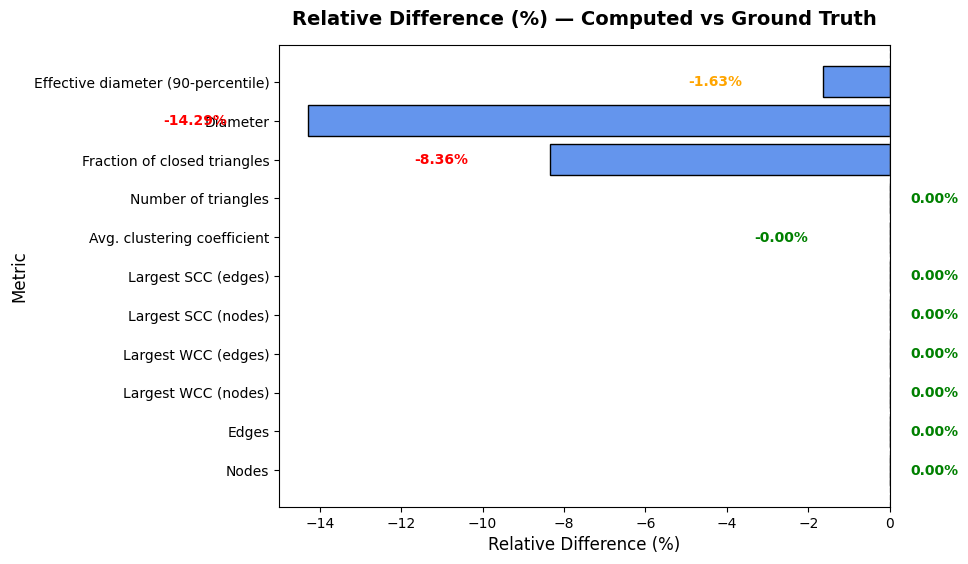


📁 Results exported → metric_comparison_results.xlsx

✅ Evaluation complete — compared 11 metrics (11 with valid computed values).


In [21]:


import pandas as pd
import matplotlib.pyplot as plt

gt = {
    "Nodes": 7115,
    "Edges": 103689,
    "Largest WCC (nodes)": 7066,
    "Largest WCC (edges)": 103663,
    "Largest SCC (nodes)": 1300,
    "Largest SCC (edges)": 39456,
    "Avg. clustering coefficient": 0.1409,
    "Number of triangles": 608389,
    "Fraction of closed triangles": 0.04564,
    "Diameter": 7.0,
    "Effective diameter (90-percentile)": 3.8,
}

def safe(v):
    try:
        return float(v)
    except:
        return None

computed = {
    "Nodes": safe(vertices.count()),
    "Edges": safe(edges.count()),
    "Largest WCC (nodes)": safe(largest_wcc_nodes),
    "Largest WCC (edges)": safe(largest_wcc_edges_directed),
    "Largest SCC (nodes)": safe(largest_scc_nodes),
    "Largest SCC (edges)": safe(largest_scc_edges),
    "Avg. clustering coefficient": safe(avg_clustering),
    "Number of triangles": safe(total_triangles),
    "Fraction of closed triangles": safe(closure_ratio),
    "Diameter": safe(diam_lb),
    "Effective diameter (90-percentile)": safe(p90),
}

rows = []
for metric, gt_val in gt.items():
    comp = computed.get(metric, None)
    absdiff = None if comp is None else comp - gt_val
    reldiff = None if comp is None or gt_val == 0 else ((comp - gt_val) / gt_val) * 100
    rows.append({
        "Metric": metric,
        "GroundTruth": gt_val,
        "Computed": comp,
        "AbsDiff": absdiff,
        "RelDiff_%": reldiff
    })

results_df = pd.DataFrame(rows)
results_df = results_df.round(4)

print("\n📋 Metric Comparison Summary:")
print(results_df.to_string(index=False))


plot_df = results_df.dropna(subset=["RelDiff_%"])

plt.figure(figsize=(11, 6))
bars = plt.barh(plot_df["Metric"], plot_df["RelDiff_%"], color="cornflowerblue", edgecolor="black")
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Relative Difference (%) — Computed vs Ground Truth", fontsize=14, weight="bold", pad=15)
plt.xlabel("Relative Difference (%)", fontsize=12)
plt.ylabel("Metric", fontsize=12)

for bar in bars:
    width = bar.get_width()
    x_offset = 0.5 if width >= 0 else -2
    color = "green" if abs(width) < 1 else ("orange" if abs(width) < 5 else "red")
    plt.text(
        width + x_offset,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2f}%",
        va="center",
        ha="left" if width >= 0 else "right",
        fontsize=10,
        color=color,
        weight="bold"
    )

# Fix overlap / padding
plt.tight_layout(pad=2)
plt.subplots_adjust(left=0.35)  # more space for long metric names
plt.show()


results_df.to_excel("metric_comparison_results.xlsx", index=False)
print("\n📁 Results exported → metric_comparison_results.xlsx")

valid = plot_df.shape[0]
print(f"\n✅ Evaluation complete — compared {len(results_df)} metrics ({valid} with valid computed values).")